## German Credit Risk

#### Contexto

O dataset original contém 1000 entradas com 20 features categóricas preparadas pelo Prof. Hofmann. Nesse dataset, cada entrada representa uma pessoa que recebe crédito de um banco. Cada pessoa é classificada como bom ou mal risco de crédito de acordo com as features. O link para o dataset é: https://www.kaggle.com/datasets/uciml/german-credit

#### Conteúdo
As features presentes no dataset são:

* Age (numeric)
* Sex (text: male, female)
* Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
* Housing (text: own, rent, or free)
* Saving accounts (text - little, moderate, quite rich, rich)
* Checking account (numeric, in DM - Deutsch Mark)
* Credit amount (numeric, in DM)
* Duration (numeric, in month)
* Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

### Instalações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, StratifiedKFold
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import shap
shap.initjs()
import warnings

from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

### Análise exploratória

Começaremos observando algumas características dos dados e em seguida visualizaremos algusn gráficos.

In [2]:
df = pd.read_csv('C:/Users/Urbanek/Documents/Data Science/Datasets/german_credit_data.csv', index_col=0)
df.head()

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [4]:
df.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

In [5]:
print("Sex: ",df['Sex'].unique())
print("Housing: ",df['Housing'].unique())
print("Saving accounts: ",df['Saving accounts'].unique())
print("Checking account: ",df['Checking account'].unique())
print("Purpose: ",df['Purpose'].unique())
print("Risk: ",df['Risk'].unique())

Sex:  ['male' 'female']
Housing:  ['own' 'free' 'rent']
Saving accounts:  [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account:  ['little' 'moderate' nan 'rich']
Purpose:  ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
Risk:  ['good' 'bad']


In [6]:
df[df['Checking account'].isna() & df['Saving accounts'].isna()].count()

Age                 99
Sex                 99
Job                 99
Housing             99
Saving accounts      0
Checking account     0
Credit amount       99
Duration            99
Purpose             99
Risk                99
dtype: int64

In [7]:
df[df['Checking account'].isna()].count()

Age                 394
Sex                 394
Job                 394
Housing             394
Saving accounts     295
Checking account      0
Credit amount       394
Duration            394
Purpose             394
Risk                394
dtype: int64

In [8]:
df[df['Saving accounts'].isna()].count()

Age                 183
Sex                 183
Job                 183
Housing             183
Saving accounts       0
Checking account     84
Credit amount       183
Duration            183
Purpose             183
Risk                183
dtype: int64

In [9]:
df[(df['Checking account']=='little') & (df['Saving accounts']=='little')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 3 to 998
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               219 non-null    int64 
 1   Sex               219 non-null    object
 2   Job               219 non-null    int64 
 3   Housing           219 non-null    object
 4   Saving accounts   219 non-null    object
 5   Checking account  219 non-null    object
 6   Credit amount     219 non-null    int64 
 7   Duration          219 non-null    int64 
 8   Purpose           219 non-null    object
 9   Risk              219 non-null    object
dtypes: int64(4), object(6)
memory usage: 18.8+ KB


In [10]:
df[(df['Checking account']=='little') & (df['Saving accounts']=='moderate')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 15 to 918
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               12 non-null     int64 
 1   Sex               12 non-null     object
 2   Job               12 non-null     int64 
 3   Housing           12 non-null     object
 4   Saving accounts   12 non-null     object
 5   Checking account  12 non-null     object
 6   Credit amount     12 non-null     int64 
 7   Duration          12 non-null     int64 
 8   Purpose           12 non-null     object
 9   Risk              12 non-null     object
dtypes: int64(4), object(6)
memory usage: 1.0+ KB


In [11]:
df[(df['Checking account']=='little') & (df['Saving accounts']=='rich')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 250 to 955
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               6 non-null      int64 
 1   Sex               6 non-null      object
 2   Job               6 non-null      int64 
 3   Housing           6 non-null      object
 4   Saving accounts   6 non-null      object
 5   Checking account  6 non-null      object
 6   Credit amount     6 non-null      int64 
 7   Duration          6 non-null      int64 
 8   Purpose           6 non-null      object
 9   Risk              6 non-null      object
dtypes: int64(4), object(6)
memory usage: 528.0+ bytes


In [12]:
df[(df['Checking account']=='little') & (df['Saving accounts']=='quite rich')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 21 to 946
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               8 non-null      int64 
 1   Sex               8 non-null      object
 2   Job               8 non-null      int64 
 3   Housing           8 non-null      object
 4   Saving accounts   8 non-null      object
 5   Checking account  8 non-null      object
 6   Credit amount     8 non-null      int64 
 7   Duration          8 non-null      int64 
 8   Purpose           8 non-null      object
 9   Risk              8 non-null      object
dtypes: int64(4), object(6)
memory usage: 704.0+ bytes


In [13]:
df[(df['Checking account']=='moderate') & (df['Saving accounts']=='little')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 1 to 989
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               152 non-null    int64 
 1   Sex               152 non-null    object
 2   Job               152 non-null    int64 
 3   Housing           152 non-null    object
 4   Saving accounts   152 non-null    object
 5   Checking account  152 non-null    object
 6   Credit amount     152 non-null    int64 
 7   Duration          152 non-null    int64 
 8   Purpose           152 non-null    object
 9   Risk              152 non-null    object
dtypes: int64(4), object(6)
memory usage: 13.1+ KB


In [14]:
df[(df['Checking account']=='rich') & (df['Saving accounts']=='little')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 34 to 986
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               41 non-null     int64 
 1   Sex               41 non-null     object
 2   Job               41 non-null     int64 
 3   Housing           41 non-null     object
 4   Saving accounts   41 non-null     object
 5   Checking account  41 non-null     object
 6   Credit amount     41 non-null     int64 
 7   Duration          41 non-null     int64 
 8   Purpose           41 non-null     object
 9   Risk              41 non-null     object
dtypes: int64(4), object(6)
memory usage: 3.5+ KB


In [15]:
df['Checking account'].isna().sum()

394

In [16]:
df['Saving accounts'].isna().sum()

183

Temos um dataset com mil linha e 9 features, apenas duas com dados faltantes. Os valores faltantes de "Checking Account" representam 39.4% dos dados e "Saving accounts" 18.3%. Poderemos substituir os valores faltantes pela moda mas antes vamos verificar alguns gráficos e o comportamento do algoritmo com os dados faltantes.

### Visualização dos dados
Começaremos vendo a distribuição do Risco e em seguida faremos algumas relações com outras features.

Text(0, 0.5, 'Count')

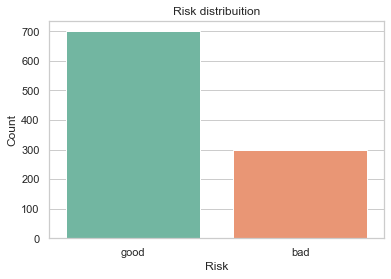

In [17]:
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="Risk", data=df, palette='Set2')
ax.set_title('Risk distribuition')
ax.set_ylabel('Count')

In [18]:
df['Age'].max()

75

Text(0, 0.5, 'Credit Amount')

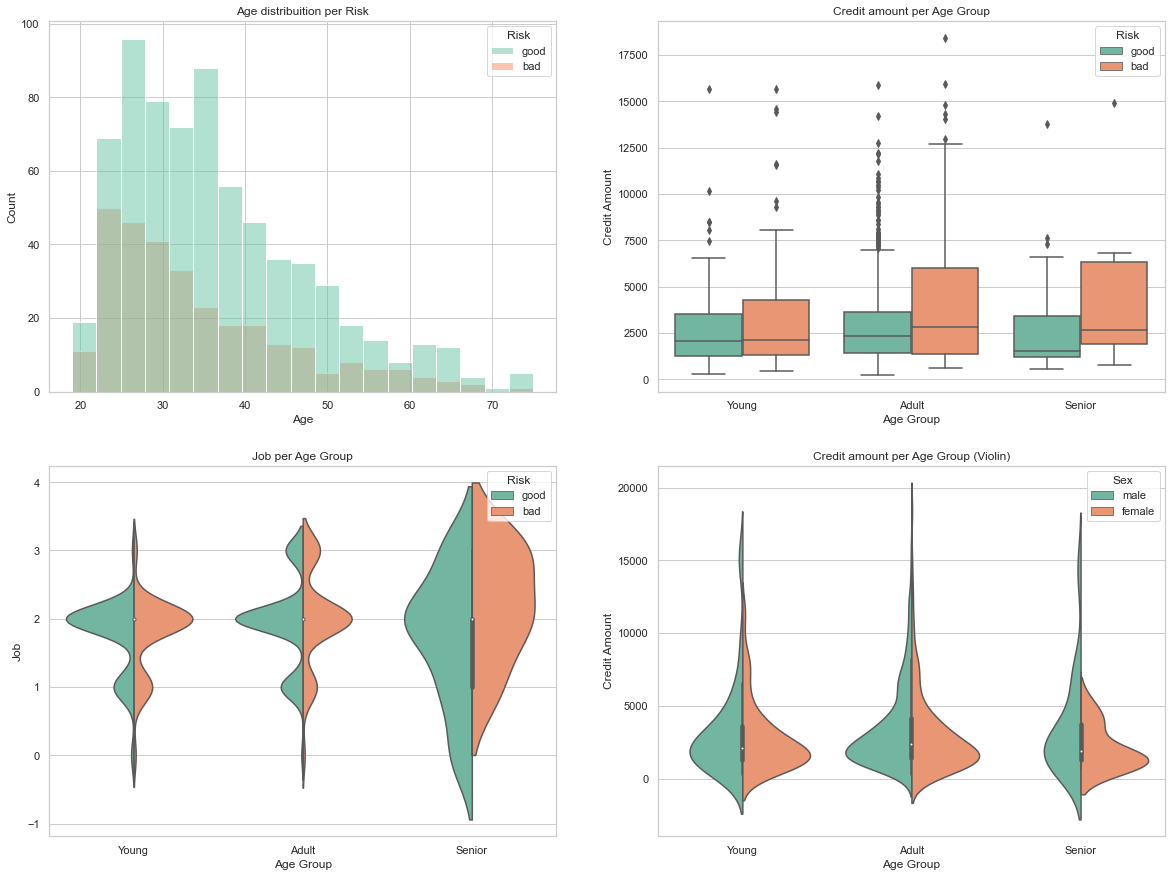

In [19]:
#vamos criar intervalos de idade 
age = (18, 25, 60, 120)
group = ['Young', 'Adult', 'Senior']
df["Age Group"] = pd.cut(df.Age, age, labels=group)

fig,ax=plt.subplots(2,2,figsize=(20,15))
sns.histplot(data=df, x="Age", hue="Risk", palette='Set2', ax=ax[0,0])
sns.boxplot(x="Age Group", y="Credit amount", hue='Risk', data=df, palette='Set2', ax=ax[0,1])
sns.violinplot(x="Age Group", y="Job", hue="Risk", data=df, palette="Set2", split=True, ax=ax[1,0])
sns.violinplot(x="Age Group", y="Credit amount", hue="Sex", data=df, palette="Set2", split=True, ax=ax[1,1])
ax[0,0].set_title('Age distribuition per Risk')
ax[0,1].set_title('Credit amount per Age Group')
ax[1,0].set_title('Job per Age Group')
ax[1,1].set_title('Credit amount per Age Group (Violin)')
ax[0,1].set_ylabel('Credit Amount')
ax[1,1].set_ylabel('Credit Amount')

Os gráficos acima nos mostram:
* Distribuição da idade e o risco relacionado
* A quantidade de crédito por grupo etário
* O tipo de trabalho por grupo etário
* A quantidade de crédito por grupo etário para cada sexo

Podemos perceber que há uma grande concentração de amostras nos grupos etários "jovem e adulto" e esses grupos possuem distribuições parecidas do tipo de trabalho.  
A distribuição de crédito nos mostra um risco pouco maior para se fazer emprestimo para o grupo "senior".

Text(0, 0.5, 'Credit Amount')

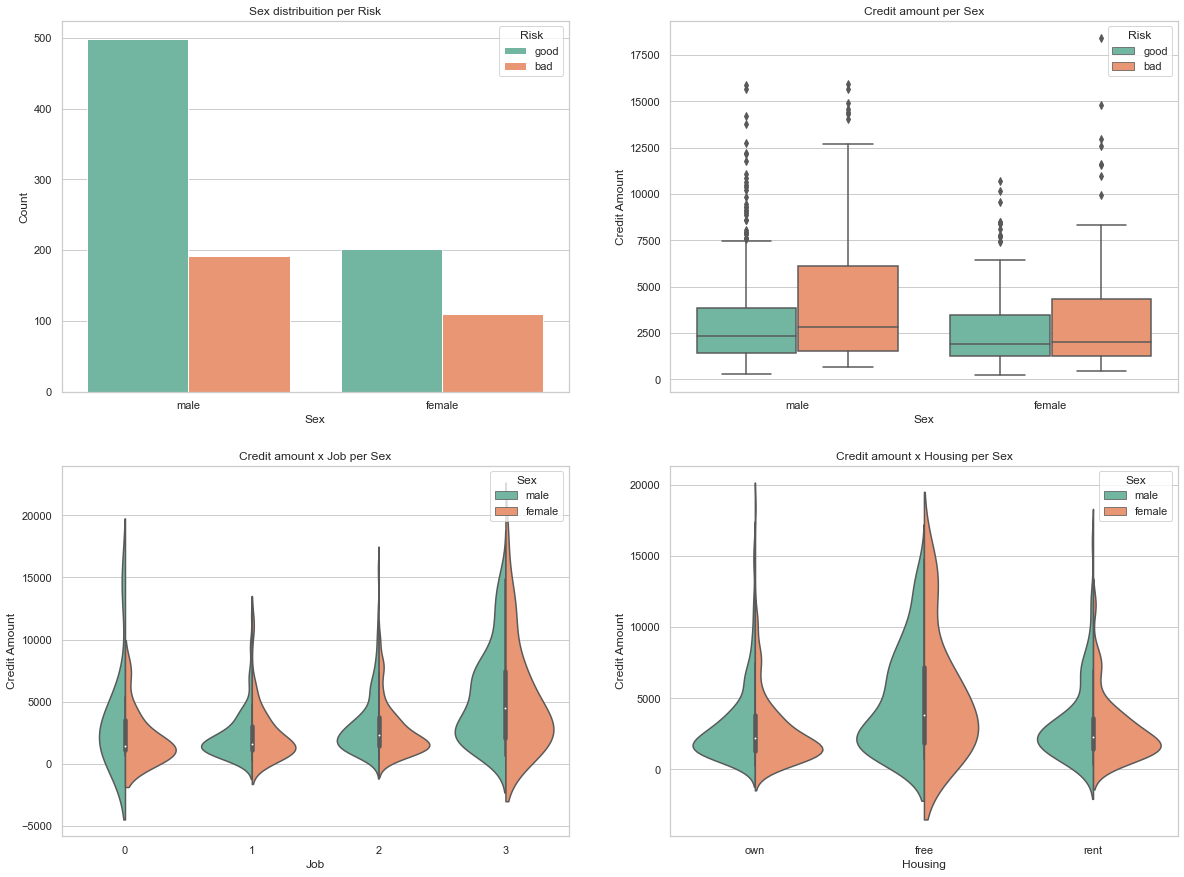

In [20]:
fig,ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot(x="Sex", hue="Risk", data=df, palette='Set2', ax=ax[0,0])
sns.boxplot(x="Sex", y="Credit amount", hue='Risk', data=df, palette='Set2', ax=ax[0,1])
sns.violinplot(x="Job", y="Credit amount", hue="Sex", data=df, palette="Set2", split=True, ax=ax[1,0])
sns.violinplot(x="Housing", y="Credit amount", hue="Sex", data=df, palette="Set2", split=True, ax=ax[1,1])
ax[0,0].set_title('Sex distribuition per Risk')
ax[0,1].set_title('Credit amount per Sex')
ax[1,0].set_title('Credit amount x Job per Sex')
ax[1,1].set_title('Credit amount x Housing per Sex')
ax[0,0].set_ylabel('Count')
ax[0,1].set_ylabel('Credit Amount')
ax[1,0].set_ylabel('Credit Amount')
ax[1,1].set_ylabel('Credit Amount')

Os gráficos acima nos mostram:
* Distribuição do sexo e o risco relacionado
* A quantidade de crédito sexo
* A quantidade de crédito por tipo de trabalho por sexo
* A quantidade de crédito por tipo de moradia por sexo

Temos uma amostragem maior de homens e esses também demonstram uma melhor proporção de risco de empréstimo.  
Embora as amostras de pessoas com casas "gratuitas" seja pequena, como veremos abaixo, o crédito em relação à esse tipo de moradia se demonstra um pouco maior, principalmente para pessoas do sexo feminino.

Text(0, 0.5, 'Credit Amount')

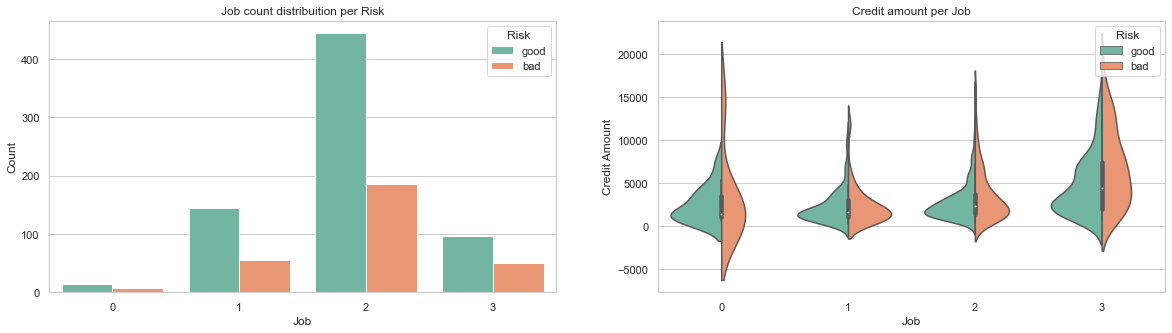

In [21]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
sns.countplot(x="Job", hue="Risk", data=df, palette='Set2', ax=ax[0])
sns.violinplot(x="Job", y="Credit amount", hue="Risk", data=df, palette="Set2", split=True, ax=ax[1])
ax[0].set_title('Job count distribuition per Risk')
ax[1].set_title('Credit amount per Job')
ax[0].set_ylabel('Count')
ax[1].set_ylabel('Credit Amount')

Os gráficos acima nos mostram:
* Distribuição do tipo de trabalho e o risco relacionado
* A quantidade de crédito por tipo de trabalho

Temos a grande maioria das amostras no tipo 2 (Qualificado) e também podemos ver que existe uma maior disponibilidade de crédito para os indivíduos do grupo 3 (muito qualificado).

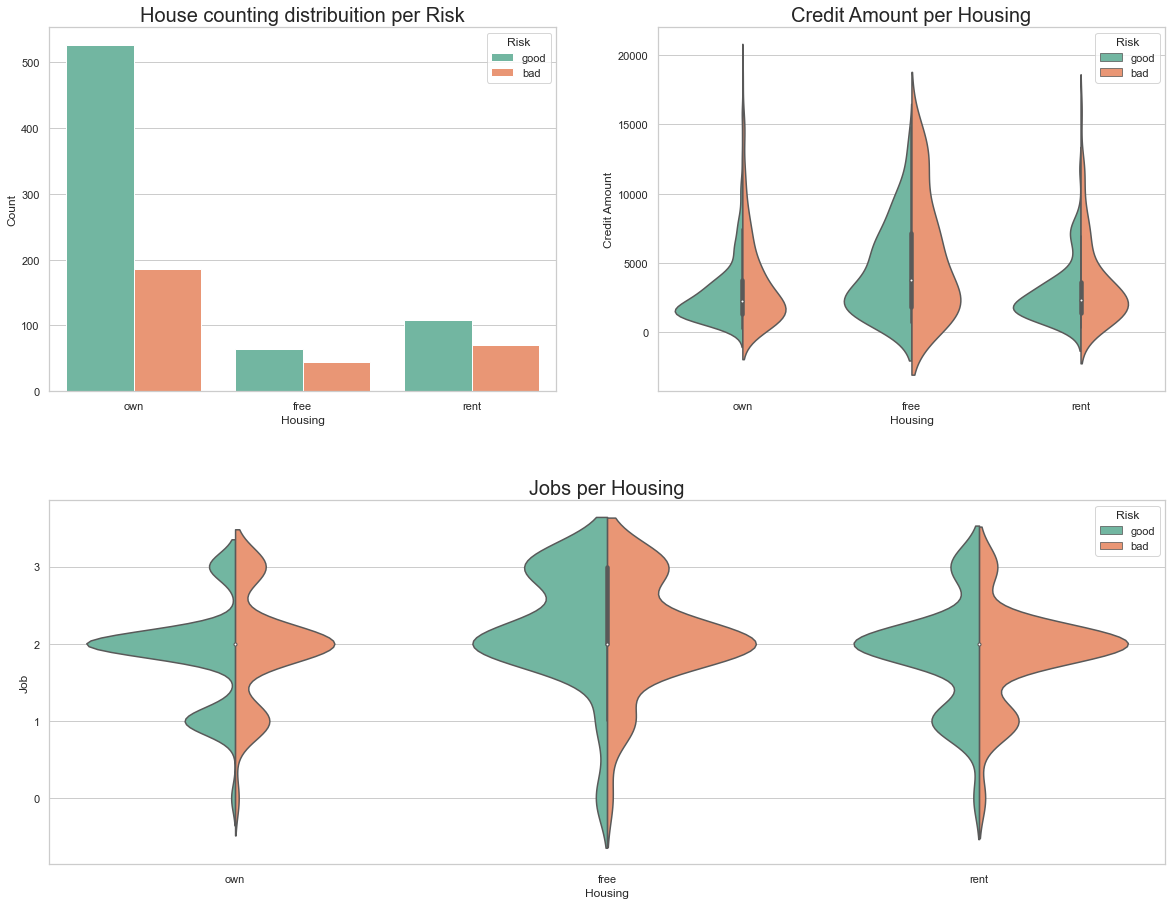

In [22]:
plt.figure(figsize = (20,15))

g = plt.subplot(221)
g = sns.countplot(x="Housing", hue="Risk", data=df, palette='Set2')
g.set_xlabel("Housing", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("House counting distribuition per Risk", fontsize=20)

g1 = plt.subplot(222)
g1 = sns.violinplot(x="Housing", y="Credit amount", hue="Risk", data=df, palette="Set2", split=True)
g1.set_xlabel("Housing", fontsize=12)
g1.set_ylabel("Credit Amount", fontsize=12)
g1.set_title("Credit Amount per Housing", fontsize=20)

g2 = plt.subplot(212)
g2 = sns.violinplot(x="Housing", y="Job", hue="Risk", data=df, palette="Set2", split=True)
g2.set_xlabel("Housing", fontsize=12)
g2.set_ylabel("Job", fontsize=12)
g2.set_title("Jobs per Housing", fontsize=20)

plt.subplots_adjust(wspace = 0.2, hspace = 0.3, top = 0.9)

plt.show()
plt.show()

#fig,ax=plt.subplots(2,2,figsize=(20,15))
#sns.countplot(x="Housing", hue="Risk", data=df, palette='Set2', ax=ax[0,0])
#sns.violinplot(x="Housing", y="Credit amount", hue="Risk", data=df, palette="Set2", split=True, ax=ax[0,1])
#sns.violinplot(x="Housing", y="Job", hue="Risk", data=df, palette="Set2", split=True, ax=ax[1,1])

Os gráficos acima nos mostram:
* Distribuição do tipo de moradia e o risco relacionado
* A quantidade de crédito por tipo de moradia
* O tipo de trabalho por tipo de moradia

Temos a maioria das amostras na categoria de casa própria e esses também demonstram um melhor risco de empréstimo.  
A grande concentração de crédito para todos os tipos de moradia fica entre 0-5000 com o maior outlier sendo da categoria casa própria.  
Nas 3 categorias de moradia, temos uma distribuição parecida do tipo de trabalho realizado, com uma maior concentração de profissionais muito qualificados e uma menor concentração de profissionais não qualificados nas amostras de pessoas em moradias "gratuitas".

Text(0, 0.5, 'Count')

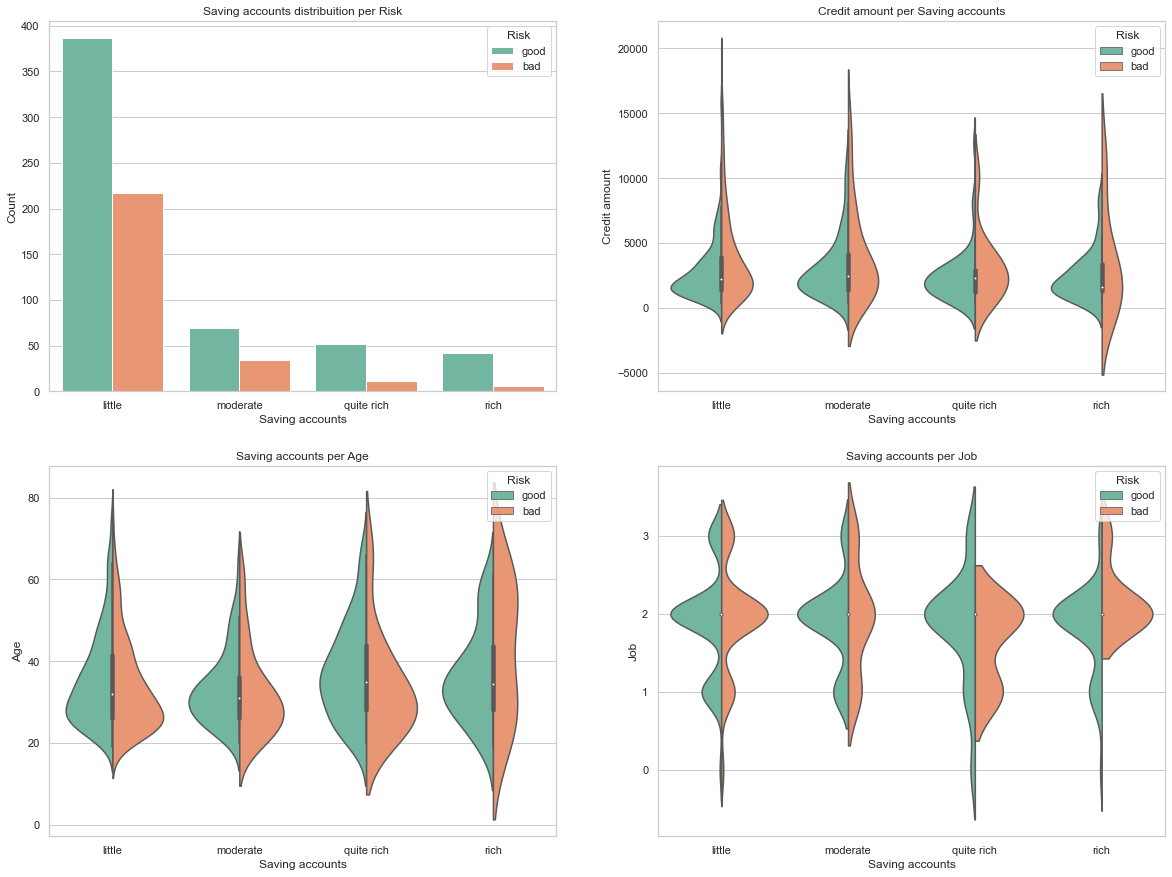

In [23]:
ordem = ['little', 'moderate', 'quite rich', 'rich']
fig,ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot(x="Saving accounts", hue="Risk", data=df, palette='Set2', order=ordem, ax=ax[0,0], hue_order=['good', 'bad'])
sns.violinplot(x="Saving accounts", y="Credit amount", hue="Risk", data=df, palette="Set2",order=ordem, split=True, ax=ax[0,1], hue_order=['good', 'bad'])
sns.violinplot(x="Saving accounts", y="Age", hue="Risk", data=df, palette="Set2",order=ordem, split=True, ax=ax[1,0], hue_order=['good', 'bad'])
sns.violinplot(x="Saving accounts", y="Job", hue="Risk", data=df, palette="Set2",order=ordem, split=True, ax=ax[1,1], hue_order=['good', 'bad'])
ax[0,0].set_title('Saving accounts distribuition per Risk')
ax[0,1].set_title('Credit amount per Saving accounts')
ax[1,0].set_title('Saving accounts per Age')
ax[1,1].set_title('Saving accounts per Job')
ax[0,0].set_ylabel('Count')

Os gráficos acima nos mostram:
* Distribuição das conta poupança e o risco relacionado
* A quantidade de crédito por conta poupança
* A idade por conta poupança
* O tipo de trabalho por conta poupança

A maior distribuição dos dados ficam nas contas poupança "pequenas" e estas, acompanhadas das "moderadas" representam um maior risco de empréstimo.  
Há uma considerável distribuição de contas poupança "ricas" entre os indivíduos de idade mais elevada.

In [24]:
(df['Checking account'] == 'moderate').sum()

269

Text(0, 0.5, 'Count')

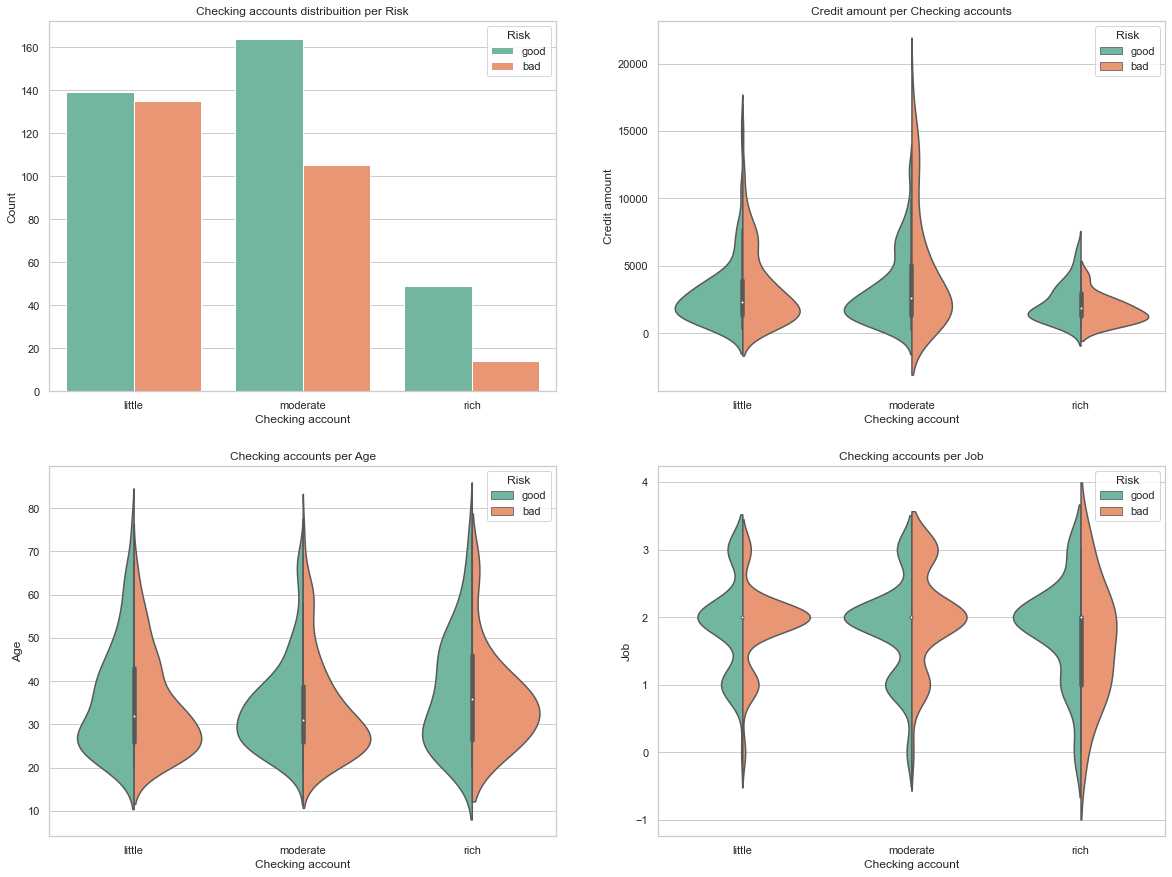

In [25]:
fig,ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot(x="Checking account", hue="Risk", data=df, palette='Set2',ax=ax[0,0])
sns.violinplot(x="Checking account", y="Credit amount", hue="Risk", data=df, palette="Set2",split=True, ax=ax[0,1])
sns.violinplot(x="Checking account", y="Age", hue="Risk", data=df, palette="Set2",split=True, ax=ax[1,0])
sns.violinplot(x="Checking account", y="Job", hue="Risk", data=df, palette="Set2",split=True, ax=ax[1,1])
ax[0,0].set_title('Checking accounts distribuition per Risk')
ax[0,1].set_title('Credit amount per Checking accounts')
ax[1,0].set_title('Checking accounts per Age')
ax[1,1].set_title('Checking accounts per Job')
ax[0,0].set_ylabel('Count')

Os gráficos acima nos mostram:
* Distribuição das conta corrente e o risco relacionado
* A quantidade de crédito por conta corrente
* A idade por conta corrente
* O tipo de trabalho por conta corrente

A maioria das amostras nos mostra contas corrente "pequenas" ou "moderadas" e essas representam grande parte do risco de empréstimo.  
Os maiores créditos aparecem para indivíduos com conta corrente "moderada" entretanto se mostram um empréstimo de risco.  
Em um pequeno contraste com as contas poupança existe uma distribuição parecida das contas corrente pela idade dos indivíduos.  

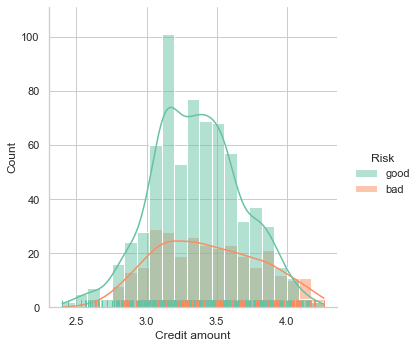

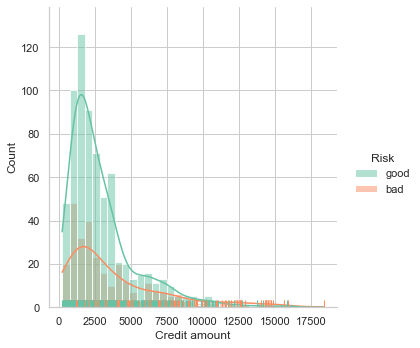

In [26]:
sns.displot(data=df, x=np.log10(df["Credit amount"]), hue="Risk", palette="Set2", kde=True, rug=True)
sns.displot(data=df, x="Credit amount", hue="Risk", palette="Set2", kde=True, rug=True)

Os gráficos acima nos mostram:
* Distribuição da quantidade de crédito e o risco relacionado (em Log10)
* Distribuição da quantidade de crédito e o risco relacionado

Podemos obeservar que a grande concentração de crédito disponível está até 5000 e temos um pouco mais de risco para os valores mais elevados.

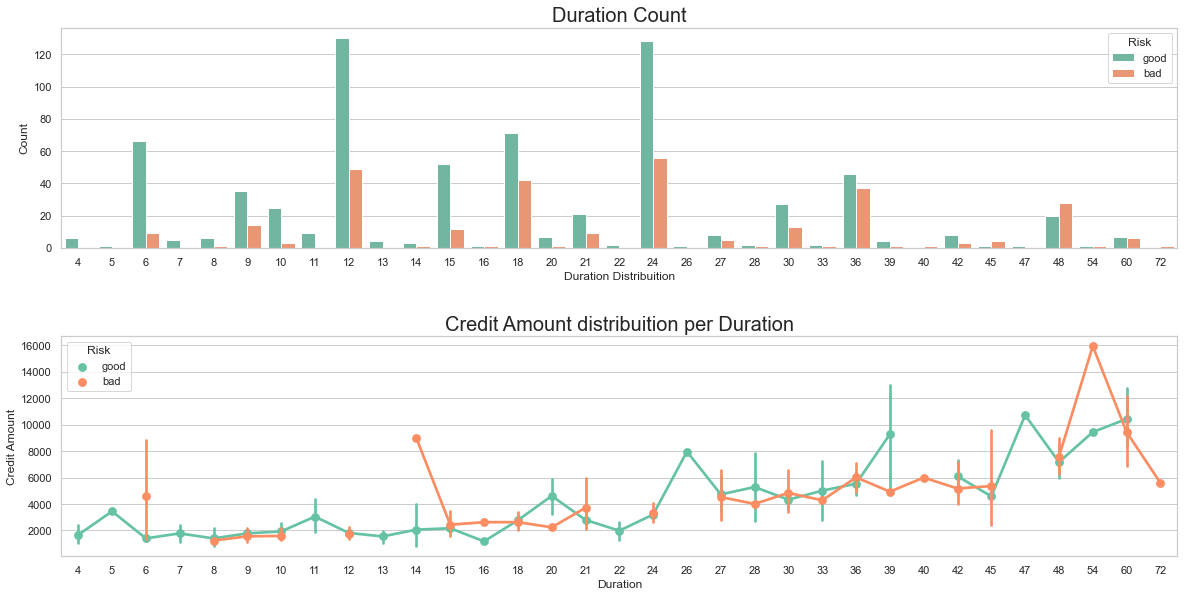

In [27]:
plt.figure(figsize = (20,15))

g= plt.subplot(311)
g = sns.countplot(x="Duration", data=df, hue="Risk", palette="Set2")
g.set_xlabel("Duration Distribuition", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Duration Count", fontsize=20)

g1 = plt.subplot(312)
g1 = sns.pointplot(x="Duration", y ="Credit amount",data=df, hue="Risk", palette="Set2")
g1.set_xlabel("Duration", fontsize=12)
g1.set_ylabel("Credit Amount", fontsize=12)
g1.set_title("Credit Amount distribuition per Duration", fontsize=20)

plt.subplots_adjust(wspace = 0.4, hspace = 0.4,top = 0.9)

plt.show()

Os gráficos acima nos mostram:
* Distribuição da duração do empréstimo e o risco relacionado
* Distribuição da quantidade de crédito em relação à duração e o risco relacionado

Podemos visualizar que o risco de crédito tem uma forte ligação com a duração dos empréstimos sendo que é pior para empréstimos mais longos.

Text(0, 0.5, 'Count')

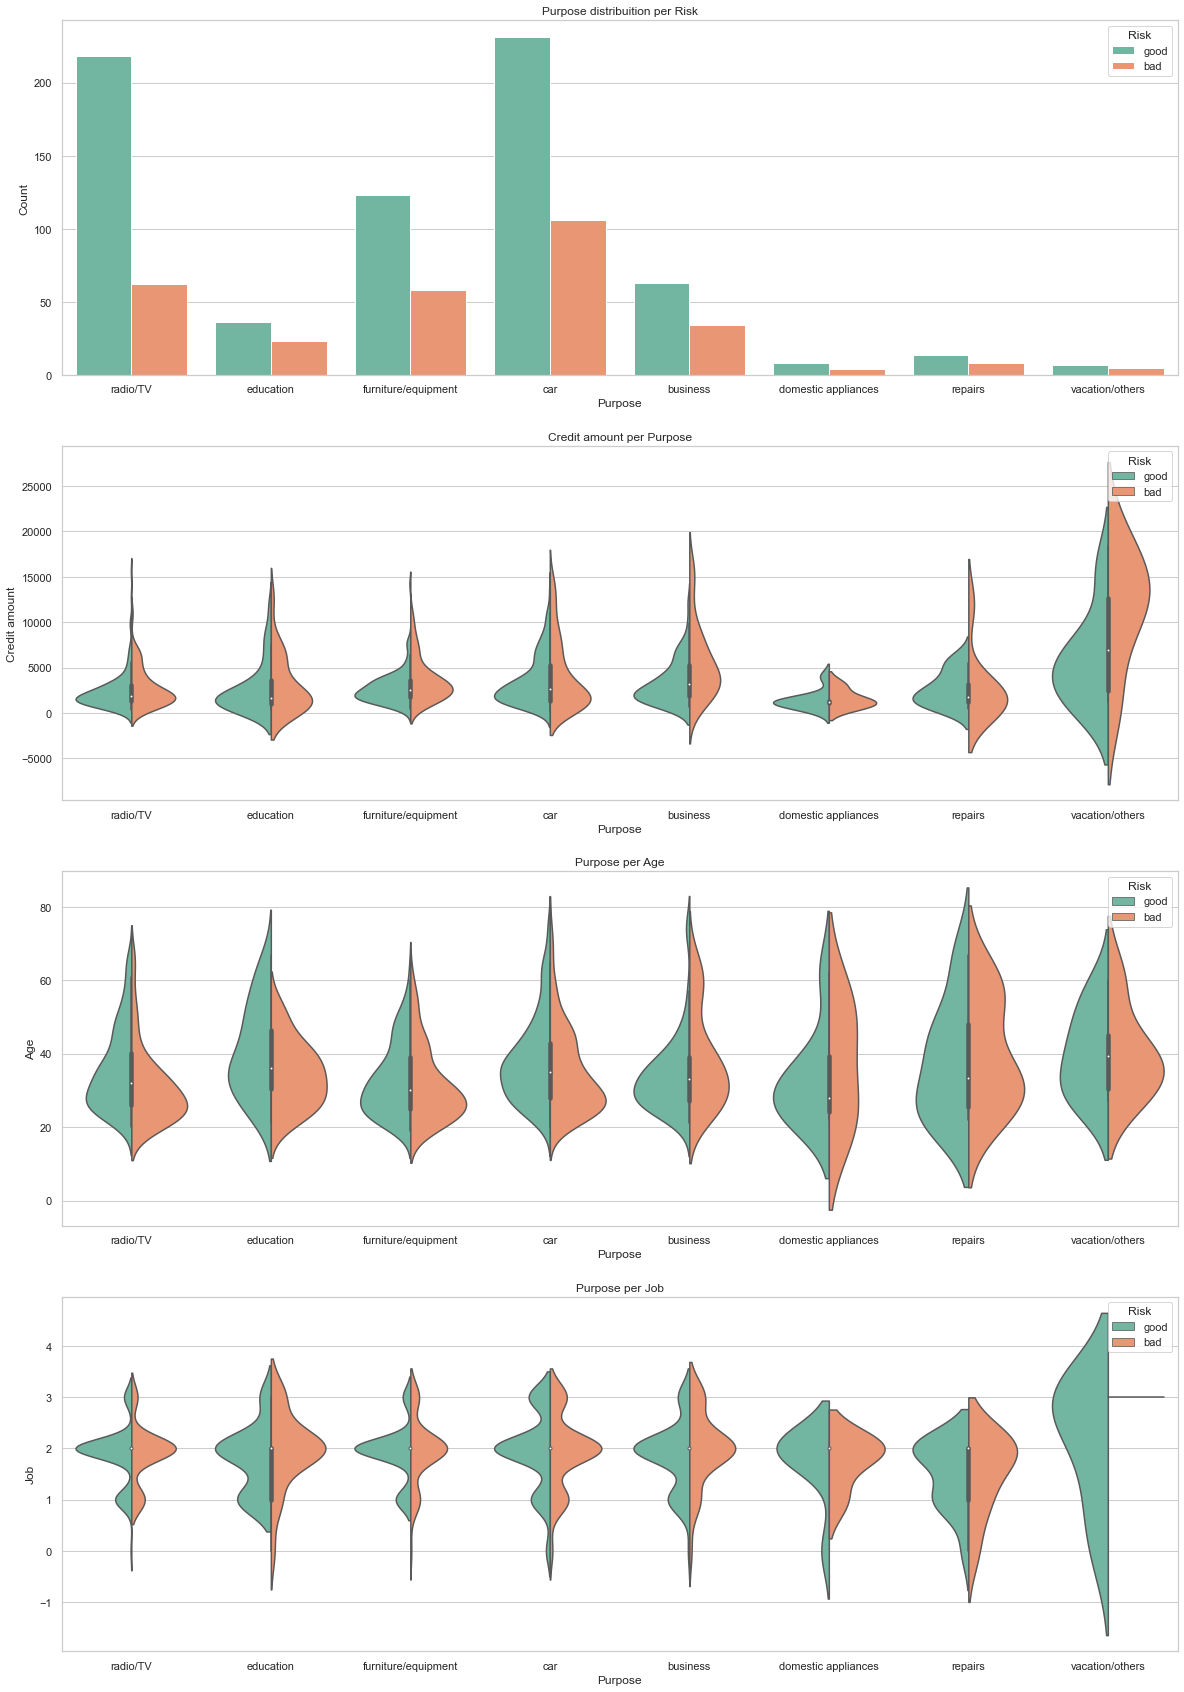

In [28]:
fig,ax=plt.subplots(4,1,figsize=(20,30))
sns.countplot(x="Purpose", hue="Risk", data=df, palette='Set2',ax=ax[0], hue_order=['good', 'bad'])
sns.violinplot(x="Purpose", y="Credit amount", hue="Risk", data=df, palette="Set2",split=True, ax=ax[1], hue_order=['good', 'bad'])
sns.violinplot(x="Purpose", y="Age", hue="Risk", data=df, palette="Set2",split=True, ax=ax[2], hue_order=['good', 'bad'])
sns.violinplot(x="Purpose", y="Job", hue="Risk", data=df, palette="Set2",split=True, ax=ax[3], hue_order=['good', 'bad'])
ax[0].set_title('Purpose distribuition per Risk')
ax[1].set_title('Credit amount per Purpose')
ax[2].set_title('Purpose per Age')
ax[3].set_title('Purpose per Job')
ax[0].set_ylabel('Count')

Os gráficos acima nos mostram:
* Distribuição do propósito e o risco relacionado
* A quantidade de crédito por propósito
* A idade por propósito
* O tipo de trabalho por propósito

Os indivíduos que procuraram empréstimo tinham como propósito, em sua maioria, carros - rádio/tv - mobílias, dos quais, para rádio/tv demonstraram um risco menor.

### Pré processamento e feature engineering

Primeiramente vamos rodar o algoritmo de LightGBM e testar sua performance com os dados inalterados (faremos apenas uma mudança no tipo das features para "categóricos")

In [29]:
df['Sex'] = df['Sex'].astype('category')
df['Housing'] = df['Housing'].astype('category')
df['Saving accounts'] = df['Saving accounts'].astype('category')
df['Checking account'] = df['Checking account'].astype('category')
df['Purpose'] = df['Purpose'].astype('category')
df['Age Group'] = df['Age Group'].astype('category')
df['Risk'] = df['Risk'].astype('category')

In [30]:
y = df['Risk']
x = df.drop('Risk', axis = 1)

In [31]:
x_treino, x_test, y_treino, y_test = train_test_split(x,y,random_state=7)

In [32]:
lgbm= LGBMClassifier(n_estimators=1000, random_state=7) 
lgbm.fit(x_treino, y_treino, eval_set=[(x_treino, y_treino), (x_test, y_test)], callbacks=[early_stopping(100), log_evaluation(10)])
lgbm

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.47617	valid_1's binary_logloss: 0.514293
[20]	training's binary_logloss: 0.390033	valid_1's binary_logloss: 0.485389
[30]	training's binary_logloss: 0.329526	valid_1's binary_logloss: 0.474942
[40]	training's binary_logloss: 0.282471	valid_1's binary_logloss: 0.482656
[50]	training's binary_logloss: 0.242828	valid_1's binary_logloss: 0.484688
[60]	training's binary_logloss: 0.213394	valid_1's binary_logloss: 0.495458
[70]	training's binary_logloss: 0.186305	valid_1's binary_logloss: 0.496993
[80]	training's binary_logloss: 0.164083	valid_1's binary_logloss: 0.503923
[90]	training's binary_logloss: 0.145062	valid_1's binary_logloss: 0.514327
[100]	training's binary_logloss: 0.127684	valid_1's binary_logloss: 0.513967
[110]	training's binary_logloss: 0.113001	valid_1's binary_logloss: 0.523855
[120]	training's binary_logloss: 0.0998611	valid_1's binary_logloss: 0.530617
[130]	training's binary

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


LGBMClassifier(n_estimators=1000, random_state=7)

In [33]:
lgbm_predict=lgbm.predict(x_test,random_state=7,num_iteration=lgbm.best_iteration_)

In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
cf_1 = confusion_matrix(y_test, lgbm_predict, labels=['bad', 'good'])

<AxesSubplot:>

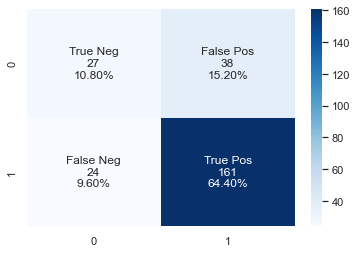

In [36]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_1.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_1.flatten()/np.sum(cf_1)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_1, annot=labels, fmt='', cmap='Blues')

Agora vamos preencher os dados faltantes com a moda e ver como o algoritmo se comporta

In [37]:
dados = df.copy()

In [38]:
dados["Saving accounts"].fillna(dados['Saving accounts'].mode()[0], inplace=True)
dados["Checking account"].fillna(dados['Checking account'].mode()[0], inplace=True)

In [39]:
Y = dados['Risk']
X = dados.drop('Risk', axis = 1)

In [40]:
X_treino, X_test, Y_treino, Y_test = train_test_split(X,Y,random_state=7)

In [41]:
LGBM= LGBMClassifier(n_estimators=1000, random_state=7) 
LGBM.fit(X_treino, Y_treino, eval_set=[(X_treino, Y_treino), (X_test, Y_test)], callbacks=[early_stopping(100), log_evaluation(10)])

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.497629	valid_1's binary_logloss: 0.547127
[20]	training's binary_logloss: 0.425843	valid_1's binary_logloss: 0.539901
[30]	training's binary_logloss: 0.368477	valid_1's binary_logloss: 0.548776
[40]	training's binary_logloss: 0.326164	valid_1's binary_logloss: 0.558005
[50]	training's binary_logloss: 0.287861	valid_1's binary_logloss: 0.561735
[60]	training's binary_logloss: 0.256937	valid_1's binary_logloss: 0.573855
[70]	training's binary_logloss: 0.230477	valid_1's binary_logloss: 0.586915
[80]	training's binary_logloss: 0.208632	valid_1's binary_logloss: 0.597872
[90]	training's binary_logloss: 0.189021	valid_1's binary_logloss: 0.608293
[100]	training's binary_logloss: 0.170584	valid_1's binary_logloss: 0.619667
[110]	training's binary_logloss: 0.155205	valid_1's binary_logloss: 0.631415
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.44243	valid_1's binary_logloss:

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


LGBMClassifier(n_estimators=1000, random_state=7)

In [42]:
lgbm_predict2=lgbm.predict(X_test,random_state=7,num_iteration=lgbm.best_iteration_)

In [43]:
cf_2 = confusion_matrix(Y_test, lgbm_predict2)

<AxesSubplot:>

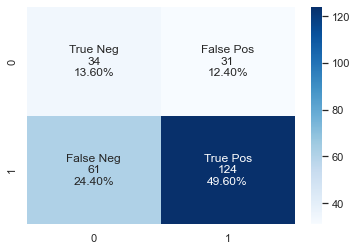

In [44]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_2.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_2.flatten()/np.sum(cf_1)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_2, annot=labels, fmt='', cmap='Blues')

Tivemos uma piora na performance do algoritmo com os dados preenchidos, vamos tentar mais alguns algoritmos de classificação.

In [45]:
def MakeClass(a, b):
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import cross_val_score
    from sklearn.preprocessing import MinMaxScaler
    
    skfold = StratifiedKFold(n_splits=5)
    
    #normalizando as variáveis
    norm = MinMaxScaler(feature_range=(0, 1))
    x_norm = norm.fit_transform(a)
    
    #testes
    log = LogisticRegression()
    knn = KNeighborsClassifier()
    naive = GaussianNB()
    dec_tree = DecisionTreeClassifier()
    
    #validação cruzada
    score = 'neg_log_loss'
    res_log = cross_val_score(log, a, b, cv = skfold, scoring=score)
    res_knn = cross_val_score(knn, x_norm, b, cv = skfold, scoring=score)
    res_naive = cross_val_score(naive, a, b, cv = skfold, scoring=score)
    res_dec_tree = cross_val_score(dec_tree, a, b, cv = skfold, scoring=score)
    
    
    melhor = {'Logística': res_log.mean(), 'KNN': res_knn.mean(), 'Naive-Bayes': res_naive.mean(), 'Decision Tree': res_dec_tree.mean() }
    return print(f'Logística: {res_log.mean()}\nKNN: {res_knn.mean()}\nNaive-Bayes: {res_naive.mean()}\nDecision Tree: {res_dec_tree.mean()}\nO melhor modelo foi o {max(melhor, key=melhor.get)} com o valor {melhor[max(melhor, key=melhor.get)]}')

Para esses algoritmos precisaremos fazer one-hot-encoding nos dados pois os mesmo só aceitam valores numéricos.

In [46]:
dados['Risk'] = dados['Risk'].replace('bad', 0)
dados['Risk'] = dados['Risk'].replace('good', 1)
dados['Sex'] = dados['Sex'].replace('male', 0)
dados['Sex'] = dados['Sex'].replace('female', 1)
housing_encode = pd.get_dummies(dados['Housing'])
saving_encode = pd.get_dummies(dados['Saving accounts'])
check_encode = pd.get_dummies(dados['Checking account'])
purp_encode = pd.get_dummies(dados['Purpose'])
drop_list = ['Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Age Group']
dados.drop(drop_list, axis = 1, inplace=True)
dados = pd.concat([dados, housing_encode, saving_encode, check_encode, purp_encode], axis = 1)

In [47]:
Y = dados['Risk']
X = dados.drop('Risk', axis = 1)

In [48]:
MakeClass(X,Y)

Logística: -0.5786739089386238
KNN: -2.1681643530445163
Naive-Bayes: -1.0072693645026507
Decision Tree: -13.021268225600773
O melhor modelo foi o Logística com o valor -0.5786739089386238


O algoritmo LightGBM teve uma melhor performance com os dados faltantes então manteremos os mesmos.

### Explicando os resultados com SHAP

In [49]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(x_treino)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Escolheremos um indivíduo como base das análises, será o de índice[4]

In [50]:
# Probabilidade de predição do conjunto de treino
y_pred_train_proba = lgbm.predict_proba(x_treino)

# Vamos agora selecionar um resultado que previu como positivo
print('Probabilidade do modelo prever negativo: ',100*y_pred_train_proba[4][0].round(2),'%.')
print('Probabilidade do modelo prever positivo: ',100*y_pred_train_proba[4][1].round(2),'%.')

Probabilidade do modelo prever negativo:  4.0 %.
Probabilidade do modelo prever positivo:  96.0 %.


O indivíduo demonstrou um ótimo valor preditivo para o valor positivo (96%), vamos verificar o que contribuiu com isto.

In [51]:
expected_value = explainer.expected_value

print('Valor esperado para classe negativa: ',100*expected_value[0].round(2))
print('Valor esperado para classe positiva: ',100*expected_value[1].round(2))

Valor esperado para classe negativa:  -105.0
Valor esperado para classe positiva:  105.0


In [52]:
shap_values_train = explainer.shap_values(x_treino, y_treino)
shap_values_train[1][4]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


array([0.18762409, 0.05333118, 0.05004686, 0.07709398, 0.3603941 ,
       0.03127741, 0.83304408, 0.54584251, 0.11495114, 0.        ])

In [53]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], x_treino.iloc[4,:])

Os valores acima representam a contribuição de cada feature na decisão do modelo, sendo o unico valor "negativo" que contribuiu com a escolha do algorítmo foi o propósito. O tamanho das barras indica a importância da feature.

In [54]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], x_treino.iloc[:1000,:])

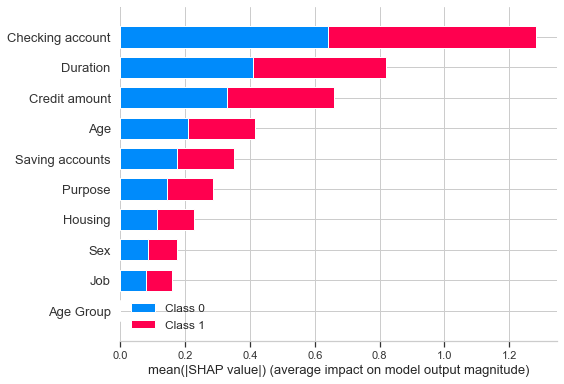

In [55]:
shap.summary_plot(shap_values, x_treino)

Temos acima as features que mais contribuem com a classificação das features, sendo a mais relevante a conta corrente e a menos relevante o tipo de trabalho.

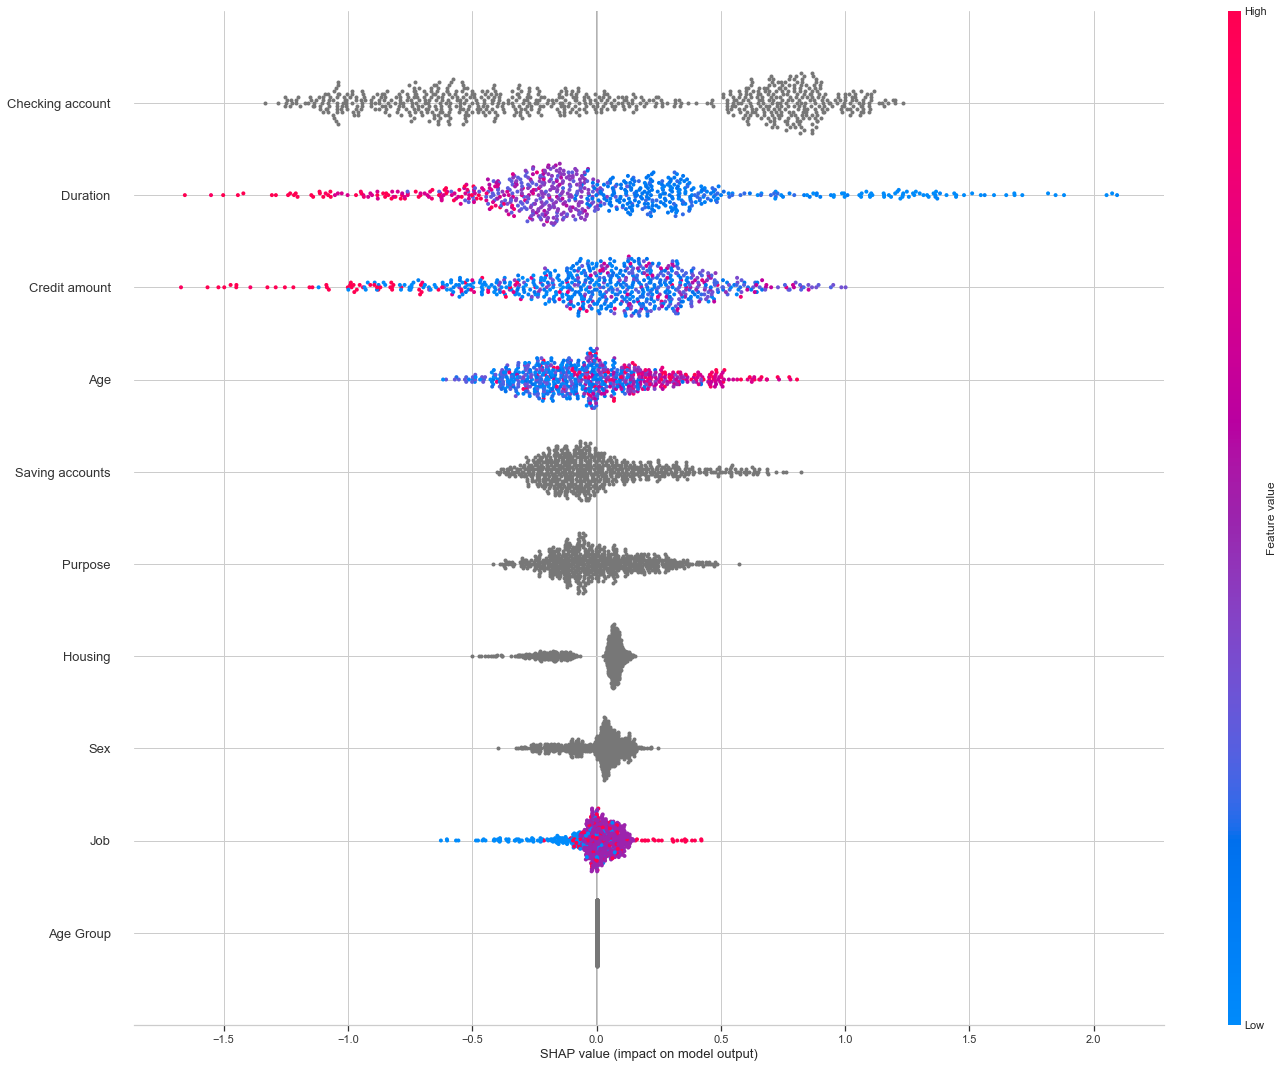

In [56]:
shap.summary_plot(shap_values_train[1], x_treino, plot_type="dot", plot_size=(20,15));

Os valores em cinza representam pontos categóricos, o algoritmo SHAP não consegue fazer uma boa diferenciação de valores não-numéricos então podemos dizer que nossa feature com maior poder preditivo é a duração do empréstimo seguido pela quantidade de crédito.

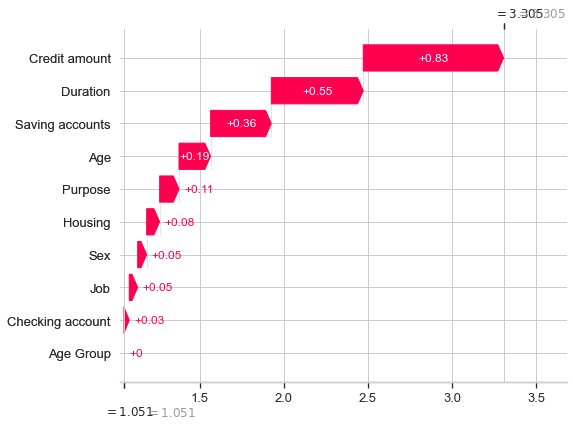

In [57]:
shap.plots._waterfall.waterfall_legacy(expected_value=expected_value[1], shap_values=shap_values_train[1][4].reshape(-1), feature_names=x_treino.columns, show=True)

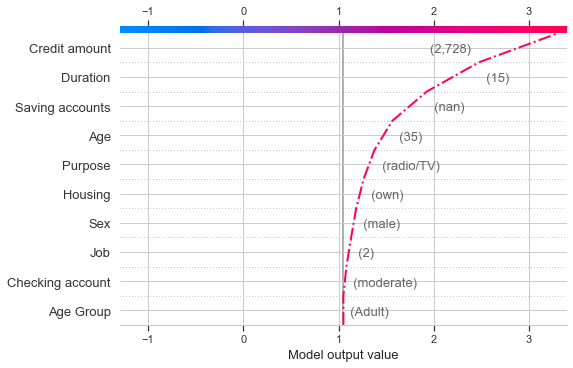

In [58]:
shap.decision_plot(base_value=expected_value[1], shap_values=shap_values_train[1][4], features=x_treino.iloc[4,:],highlight=0)

Acima podemos ver como cada variavel contribuiu com a saída dada pelo algoritmo de modo a ter classificado o empréstimo como 'seguro'.